In [69]:
import pandas, numpy
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
data = pandas.read_csv("Twitter-Absolute-Sigma-500.csv", sep=",",encoding="utf8",index_col=0)


Retirer des données à étudier la dernière colonne correspondant au résultat (buzz ou pas buzz)

In [91]:
df = data.iloc[:, :76]
print(df.shape)
df.head(n=5)

(140707, 76)


,NCD_1,NCD_2,NCD_3,NCD_4,NCD_5,NCD_6,AI_0,AI_1,AI_2,AI_3,...,ADL_4,ADL_5,ADL_6,NAD_0,NAD_1,NAD_2,NAD_3,NAD_4,NAD_5,NAD_6
NCD_0,,,,,,,,,,,,,,,,,,,,,
889,939,960,805,805,1143,1121,549,613,587,447,...,1,1,1,889,939,960,805,805,1143,1121
542,473,504,626,647,795,832,366,288,318,445,...,1,1,1,542,473,504,626,647,795,832
92,99,196,100,184,79,162,66,59,118,58,...,1,1,1,92,99,196,100,184,79,162
90,87,92,344,184,848,184,83,78,76,288,...,1,1,1,90,87,92,344,184,848,184
169,98,101,90,96,95,185,141,68,85,73,...,1,1,1,169,98,101,90,96,95,185


# Choix du nombre d'axes à retenir

Pour le choix des axes principaux, on applique le critère de Kaiser.
Ce qui veut dire qu'on ne garde que les composantes principales d'inertie expliquée supérieure à 1

In [92]:
pca = PCA(n_components = 20)
pca.fit((df - df.mean()) / df.std())
np.sort(pca.explained_variance_)


array([  0.4458573 ,   0.5240428 ,   0.64025724,   0.67095869,
         0.74407226,   0.92119248,   0.9317942 ,   1.05956245,
         1.14491036,   1.25500261,   1.33328964,   1.56513762,
         1.61262001,   1.78811233,   2.13958212,   2.23086413,
         2.60820266,   3.76766446,   6.44206188,  42.46931573])

Nous en déduisons que le nombre d'axes est donc égal à 13

In [93]:
pca = PCA(n_components = 13)
pca.fit((df - df.mean()) / df.std())
print("la part d'inertie expliquée avec les 13 composantes : ",sum(pca.explained_variance_ratio_))


la part d'inertie expliquée avec les 13 composantes :  0.913379201969


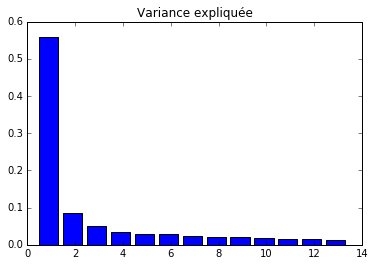

In [94]:
%matplotlib inline
plt.bar(numpy.arange(len(pca.explained_variance_ratio_))+0.5, pca.explained_variance_ratio_)
plt.title("Variance expliquée")

In [61]:
import numpy as np
X_reduced = pca.transform(df)
i = np.identity(df.shape[1])
coef = pca.transform(i)
coef
#X_reduced_df = pandas.DataFrame(X_reduced)
#X_reduced_df.head(n=5)

array([[  2.04824939e-04,   1.30351968e-05,  -3.49946196e-06, ...,
          9.19766104e-07,  -1.97739374e-04,   3.85039719e-05],
       [  2.04824939e-04,   1.30351968e-05,  -3.49946196e-06, ...,
          9.19766105e-07,  -1.97739374e-04,   3.85039719e-05],
       [  2.04824939e-04,   1.30351968e-05,  -3.49946196e-06, ...,
          9.19766105e-07,  -1.97739374e-04,   3.85039719e-05],
       ..., 
       [  2.31659955e-01,   1.99826069e-02,  -1.81302604e-02, ...,
         -1.99080629e-03,  -6.69821697e-03,   7.48424992e-03],
       [  2.30835968e-01,   1.98027151e-02,  -1.65020726e-02, ...,
          2.00892674e-03,  -1.06745165e-02,   6.26178712e-03],
       [  1.51493182e-01,  -2.26877268e-02,   7.06927290e-02, ...,
          2.04298659e-02,  -9.55016224e-01,   3.03718153e-02]])

In [63]:
tab =pandas.DataFrame(coef, columns=['PC-1', 'PC-2','PC-3','PC-4', 'PC-5', 'PC-6', 'PC-7', 'PC-8', 'PC-9', 'PC-10','PC-11','PC-12','PC-13'], index=df.columns)
test = tab["PC-1"]
test

NCD_1         0.000205
NCD_2         0.000205
NCD_3         0.000205
NCD_4         0.000205
NCD_5         0.000205
NCD_6         0.000205
AI_0          0.000205
AI_1          0.000205
AI_2          0.000205
AI_3          0.000205
AI_4          0.000205
AI_5          0.000205
AI_6          0.000205
AS(NA)_0      0.240338
AS(NA)_1      0.237494
AS(NA)_2      0.235674
AS(NA)_3      0.237581
AS(NA)_4      0.239448
AS(NA)_5      0.241100
AS(NA)_6      0.237233
BL_0          0.038196
BL_1          0.030631
BL_2          0.041866
BL_3          0.040077
BL_4          0.039037
BL_5          0.032039
BL_6          0.024735
NAC_0         0.000205
NAC_1         0.000205
NAC_2         0.000205
                ...   
CS_6          0.000205
AT_0          0.012714
AT_1          0.009563
AT_2          0.015119
AT_3          0.015292
AT_4          0.010696
AT_5          0.007021
AT_6          0.001668
NA_0          0.000205
NA_1          0.000205
NA_2          0.000205
NA_3          0.000205
NA_4       

In [3]:
from sklearn.decomposition import IncrementalPCA
n_components = 10
ipca = IncrementalPCA(n_components=n_components, batch_size=100)
X_ipca = ipca.fit_transform(df)

In [4]:
%matplotlib inline
X_reduced = X_ipca
plt.figure(figsize=(18,6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
for label, x, y in zip(df.index, X_reduced[:, 0], X_reduced[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))


KeyboardInterrupt: 